In [ ]:
import urllib
from IPython.display import Markdown as md
_nb_loc = "03_image_models/03m_transformer_flowers104.ipynb" # change to reflect your notebook
_nb_title = "Transformer Image Classification on 104 flowers" # change to reflect your notebook
_nb_message = "This notebook is set up to run on TPU or GPU. It has been executed on an Nvidia T4." # change to reflect your notebook
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Transformer+Image+Classification+on+104+flowers&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F03_image_models%2F03m_transformer_flowers104.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03m_transformer_flowers104.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/03_image_models/03m_transformer_flowers104.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/03_image_models/03m_transformer_flowers104.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Transformer Image Classification on 104 flowers</h1>This notebook is set up to run on TPU or GPU. It has been executed on an Nvidia T4.

In [ ]:
import math, re, os, sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import torch
print(torch.__version__)
device_name = torch.cuda.current_device()
print(f'GPU: {device_name}')

2.5.1+cu121
GPU: 0


# Configuration

# Надо переобучить с добавлением линейных слоев так чтобы логитов было 104

# Datasets

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msheriey/104-flowers-garden-of-eden")

print("Path to dataset files:", path)

100%|██████████| 1.75G/1.75G [00:08<00:00, 214MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msheriey/104-flowers-garden-of-eden/versions/1


In [ ]:
import matplotlib.pylab as plt
import numpy as np
import cv2
from glob import glob
import os

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_img(filename, shape):
    img = cv2.imread(filename)
    img = img[..., ::-1]
    img = cv2.resize(img, shape)
    return img.astype(float) / 255

CLASSES = glob(f"{path}/jpeg-224x224/val/*")
CLASSES = [os.path.basename(x) for x in CLASSES]
CLASSES = [x for x in CLASSES if not '.' in x]

In [ ]:
# !ls /root/.cache/kagglehub/datasets/msheriey/104-flowers-garden-of-eden/versions/1/jpeg-224x224/val/'pink primrose'/

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from glob import glob

class FlowersDataset(Dataset):
    def __init__(self, img_paths, transform=None, target_transform=None):
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_img(img_path, [IMG_HEIGHT, IMG_WIDTH]).astype(float)
        label = img_path.split("/")[11]
        label = np.argmax(np.equal(CLASSES, label))
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image.transpose(2, 0, 1), label

# This dataset is split three ways, training, validation, test
# but we will use it split two ways only: training and validation.
train_dir = "/root/.cache/kagglehub/datasets/msheriey/104-flowers-garden-of-eden/versions/1/jpeg-224x224/train"
val_dir = "/root/.cache/kagglehub/datasets/msheriey/104-flowers-garden-of-eden/versions/1/jpeg-224x224/val"

train_img_paths = glob(f"{train_dir}/*/*.jpeg")
val_img_paths = glob(f"{val_dir}/*/*.jpeg")

train_dataset = FlowersDataset(train_img_paths)
val_dataset = FlowersDataset(val_img_paths)

In [ ]:
print(f"Train dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}")

Train dataset: 12753, val_dataset: 3712


In [ ]:
from torchvision import transforms

BATCH_SIZE = 32

preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=4)

## Visualization utilities
data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 8.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image.transpose(1, 2, 0), title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot, zoom_pcent=None, ylim=None):
    # zoom_pcent: X autoscales y axis for the last X% of data points
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation,'--')
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    if zoom_pcent is not None:
        ylen = len(training)*(100-zoom_pcent)//100
        ymin = min([min(training[ylen:]), min(validation[ylen:])])
        ymax = max([max(training[ylen:]), max(validation[ylen:])])
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim([ymin-(ymax-ymin)/20, ymax+(ymax-ymin)/20])
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Dataset visualizations

In [ ]:
train_batch = iter(trainloader)

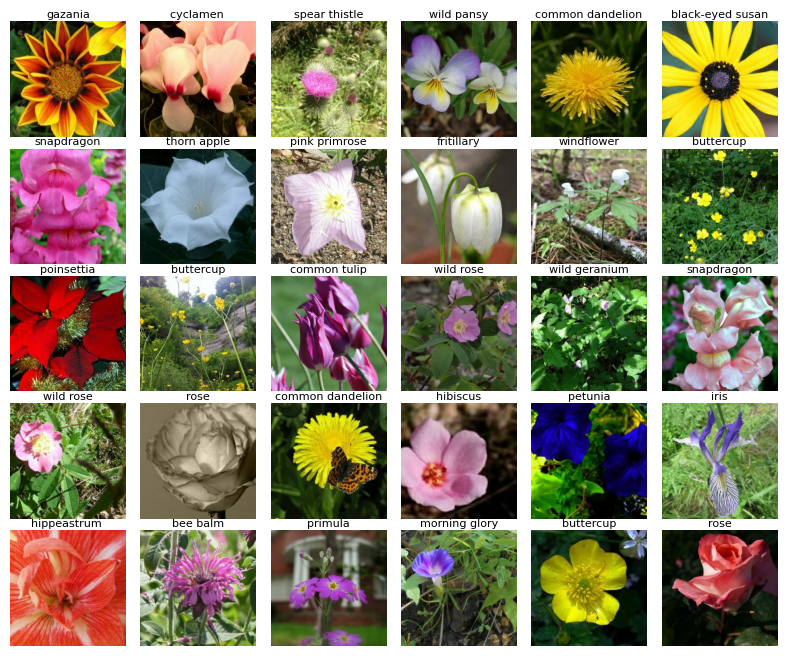

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

# Helper functions

In [ ]:
# Helper functions
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
def training_plot(history):
    f, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].plot(history['train_loss'])
    ax[0].plot(history['val_loss'], ls='dashed')
    ax[1].plot(history['train_accuracy'])
    ax[1].plot(history['val_accuracy'], ls='dashed')
    ax[0].set_xlabel("Epochs")
    ax[1].set_xlabel("Epochs")
    ax[0].legend(['train_loss', 'val_loss'], fontsize=15)
    ax[1].legend(['train_accuracy', 'val_accuracy'], fontsize=15)

# Call model.predict() on a few images in the evaluation dataset
device = "cuda:0"
s = torch.nn.Softmax(dim=1)
def plot_predictions(model, dataset):
    matplotlib.rcParams.update({'font.size': 14})
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset):
        if idx > 14:
            break
        ax[idx//5, idx%5].imshow((img.transpose(1, 2, 0)));
        batch_img = torch.unsqueeze(torch.Tensor(img), 0)
        batch_img = batch_img.to(torch.float64).to(device)
        batch_img
        with torch.no_grad():
            ## forward + loss
            logits = model(batch_img)
            probs = s(logits)
            preds = torch.argmax(probs, dim=1)
        label = CLASSES[label]
        pred_label = CLASSES[preds[0]]
        ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, torch.max(probs)))
        ax[idx//5, idx%5].axis('off')

## compute accuracy
def get_accuracy(inputs, target, batch_size):
    ''' Obtain accuracy for training round '''
    accuracy = torch.sum(inputs == target) / batch_size
    return accuracy.item()

In [ ]:
def train_loop(model,
               trainloader,
               valloader,
               criterion,
               optimizer,
            #    lr_scheduler,
            #    warmup_scheduler,
               num_epochs=10,
               batch_size=32,
               l1=0,
               l2=0
               ):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': [],
        'lr': []
    }

    model = model.to(dtype=torch.float64)

    for epoch in range(num_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        val_loss = 0.0
        val_accuracy = 0.0

        model = model.train()

        ## training step
        for i, (images, labels) in enumerate(trainloader):
            images = preprocess(images)
            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Apply L1 regularization
            if l1 > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += l1 * l1_norm

            # Apply L2 regularization
            elif l2 > 0:
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += l2 * l2_norm

            optimizer.zero_grad()
            loss.backward()

            ## update model params
            optimizer.step()

            train_loss += loss.detach().item()

            probs = s(logits)
            inputs = torch.argmax(probs, dim=1)
            train_accuracy += get_accuracy(inputs, labels, batch_size)

        ## update lr
        # for g in optimizer.param_groups:
        #     g['lr'] = lrfn(epoch)

        history['train_loss'].append(train_loss / len(trainloader))
        history['train_accuracy'].append(train_accuracy/len(trainloader))
        history['lr'].append(optimizer.param_groups[0]['lr'])
        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_loss / len(trainloader), train_accuracy / len(trainloader)))

        ## validation step
        model.eval()
        for i, (images, labels) in enumerate(valloader):

            images = preprocess(images)
            images = images.to(device_name)
            labels = labels.to(device_name)

            with torch.no_grad():
                ## forward + loss
                logits = model(images)
                loss = criterion(logits, labels)

                val_loss += loss.detach().item()

                probs = s(logits)
                inputs = torch.argmax(probs, dim=1)
                val_accuracy += get_accuracy(inputs, labels, batch_size)

        history['val_loss'].append(val_loss / len(valloader))
        history['val_accuracy'].append(val_accuracy/len(valloader))

    return history

In [ ]:
def train_and_evaluate(trainloader,
                       valloader,
                       num_epochs=10,
                       lr_start = 1e-3, # default in Adam constructor
                       l1 = 0,
                       l2 = 0
                       ):

    model = CustomModel()
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start, eps=1e-4)

    history = train_loop(model, trainloader, valloader, criterion, optimizer, num_epochs, l1=l1, l2=l2)
    training_plot(history)
    return model, history

# Model 1: DenseNet201

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class CustomModel(nn.Module):
    def __init__(self) -> None:
        super(CustomModel, self).__init__()
        self.densenet121 = torchvision.models.densenet121(weights='DEFAULT')
        self.pool = torch.nn.functional.adaptive_avg_pool2d
        self.linear1 = torch.nn.Linear(1024, 104)

    def forward(self, x):
        x = self.densenet121.features(x)
        x = self.pool(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return x


In [ ]:
model = CustomModel()

In [ ]:
images = next(iter(trainloader))[0].float()
logits = model(images)

In [ ]:
logits.shape

torch.Size([32, 104])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 146MB/s]


Epoch: 0 | Loss: 6.5686 | Train Accuracy: 0.07
Epoch: 1 | Loss: 5.1745 | Train Accuracy: 0.30
Epoch: 2 | Loss: 3.8243 | Train Accuracy: 0.47
Epoch: 3 | Loss: 2.7912 | Train Accuracy: 0.57
Epoch: 4 | Loss: 2.0887 | Train Accuracy: 0.64
Epoch: 5 | Loss: 1.6348 | Train Accuracy: 0.69
Epoch: 6 | Loss: 1.3245 | Train Accuracy: 0.74
Epoch: 7 | Loss: 1.0970 | Train Accuracy: 0.78
Epoch: 8 | Loss: 0.9201 | Train Accuracy: 0.81
Epoch: 9 | Loss: 0.7841 | Train Accuracy: 0.84


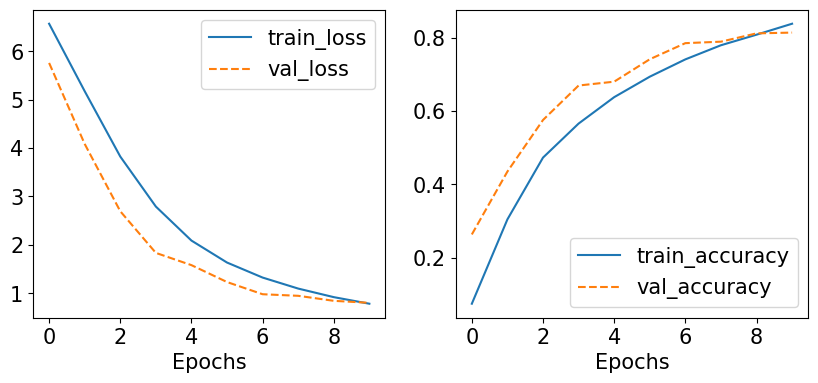

In [ ]:
model, history = train_and_evaluate(trainloader, valloader)

In [ ]:
# save trained model
torch.save(model.state_dict(), "densenet121.pt")

In [ ]:
# from torchvision import models
# from torchsummary import summary

# summary(model, (3, 224, 224))

## Confusion matrix

In [ ]:
import math, re, os, sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

cm_correct_labels = []
cm_predictions = []

## validation step
model.eval()
for i, (images, labels) in enumerate(valloader):

    images = preprocess(images)
    images = images.to(device)
    cm_correct_labels.extend(list(labels.numpy()))

    with torch.no_grad():
        ## forward + loss
        logits = model(images)
        probs = s(logits)
        outputs = torch.argmax(probs, dim=1)
        cm_predictions.extend(list(outputs.cpu().numpy()))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


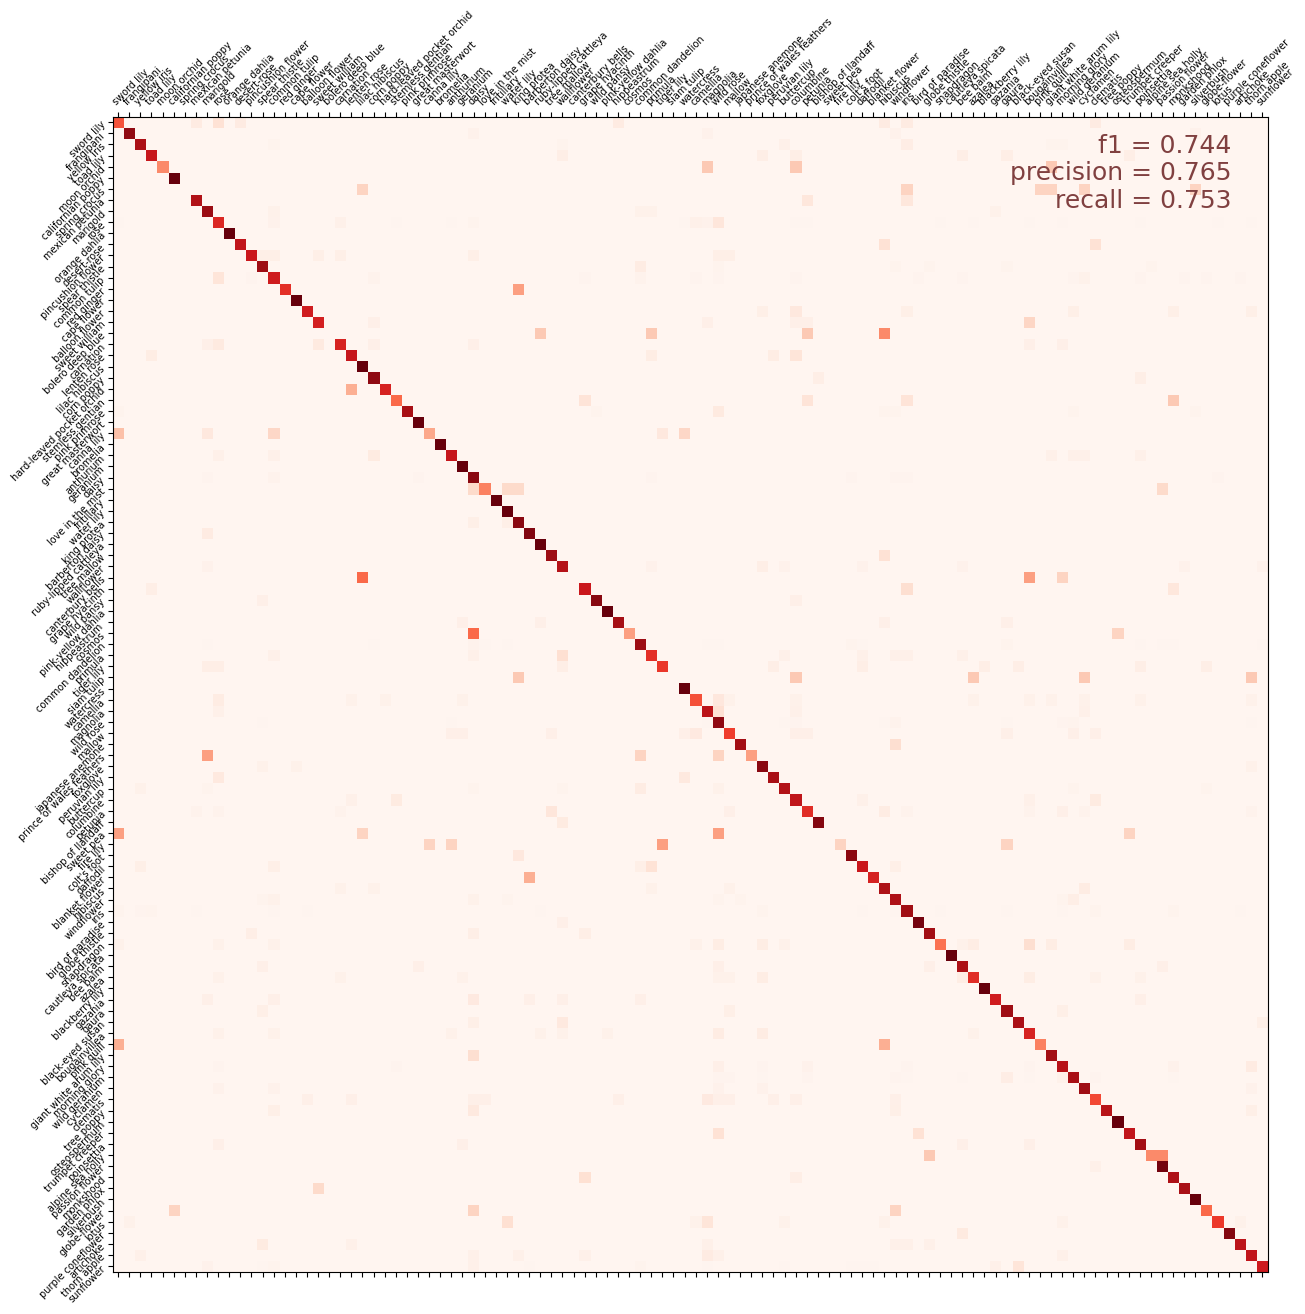

f1 score: 0.744, precision: 0.765, recall: 0.753


In [ ]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Model 2: EfficientNetB6

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class CustomModel(nn.Module):
    def __init__(self) -> None:
        super(CustomModel, self).__init__()
        self.efficientnet_b6 = torchvision.models.efficientnet_b6(weights='DEFAULT')
        self.pool = torch.nn.functional.adaptive_avg_pool2d
        self.linear1 = torch.nn.Linear(2304, 104)

    def forward(self, x):
        x = self.efficientnet_b6.features(x)
        x = self.pool(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return x


Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth
100%|██████████| 165M/165M [00:03<00:00, 52.0MB/s]


Epoch: 0 | Loss: 3.7522 | Train Accuracy: 0.54
Epoch: 1 | Loss: 2.0025 | Train Accuracy: 0.73
Epoch: 2 | Loss: 1.4140 | Train Accuracy: 0.80
Epoch: 3 | Loss: 1.0356 | Train Accuracy: 0.85
Epoch: 4 | Loss: 0.8152 | Train Accuracy: 0.88
Epoch: 5 | Loss: 0.6748 | Train Accuracy: 0.90
Epoch: 6 | Loss: 0.5582 | Train Accuracy: 0.91
Epoch: 7 | Loss: 0.4606 | Train Accuracy: 0.93
Epoch: 8 | Loss: 0.4404 | Train Accuracy: 0.93
Epoch: 9 | Loss: 0.3777 | Train Accuracy: 0.94


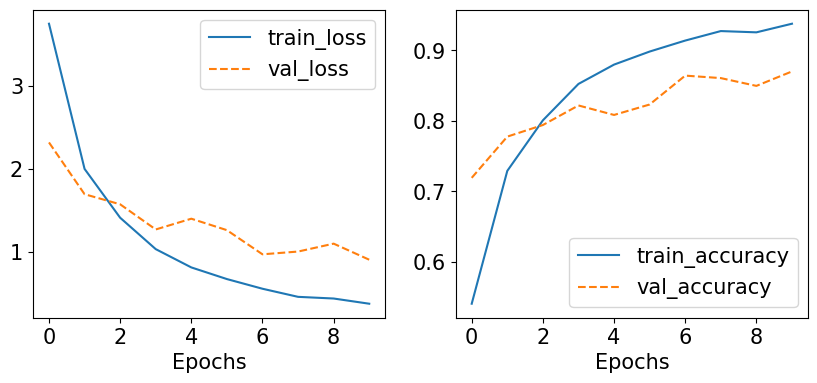

In [ ]:
efficientnetb6_model, history = train_and_evaluate(trainloader, valloader)

In [ ]:
# save trained model
torch.save(efficientnetb6_model.state_dict(), "efficientnet_b6.pt")

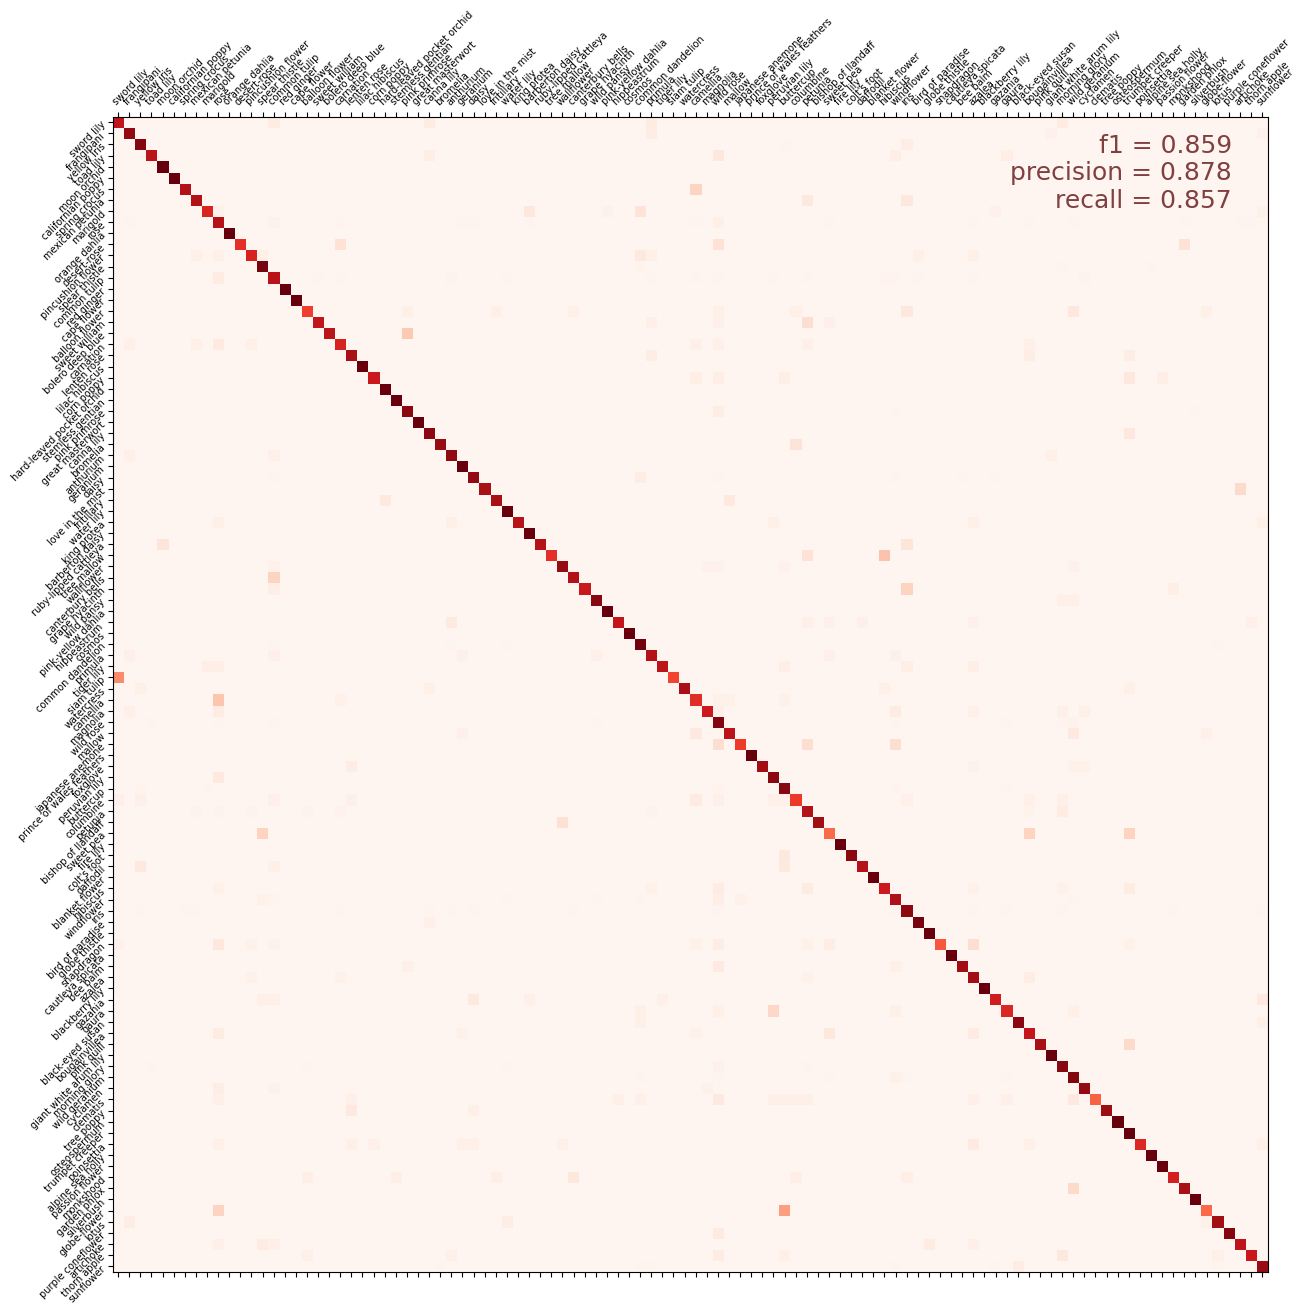

f1 score: 0.859, precision: 0.878, recall: 0.857


In [ ]:
import math, re, os, sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

cm_correct_labels = []
cm_predictions = []

## validation step
efficientnetb6_model.eval()
for i, (images, labels) in enumerate(valloader):

    images = preprocess(images)
    images = images.to(device)
    cm_correct_labels.extend(list(labels.numpy()))

    with torch.no_grad():
        ## forward + loss
        logits = efficientnetb6_model(images)
        probs = s(logits)
        outputs = torch.argmax(probs, dim=1)
        cm_predictions.extend(list(outputs.cpu().numpy()))

cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Model 3: Xception

https://pprp.github.io/timm/#welcome

In [ ]:
! pip install timm

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import timm
model = timm.create_model('xception', pretrained=True, num_classes=104)
model.eval();

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch: 0 | Loss: 1.5453 | Train Accuracy: 0.62
Epoch: 1 | Loss: 0.6215 | Train Accuracy: 0.83
Epoch: 2 | Loss: 0.3924 | Train Accuracy: 0.89
Epoch: 3 | Loss: 0.2731 | Train Accuracy: 0.92
Epoch: 4 | Loss: 0.2389 | Train Accuracy: 0.93
Epoch: 5 | Loss: 0.1789 | Train Accuracy: 0.95
Epoch: 6 | Loss: 0.1716 | Train Accuracy: 0.95
Epoch: 7 | Loss: 0.1468 | Train Accuracy: 0.95
Epoch: 8 | Loss: 0.1170 | Train Accuracy: 0.96
Epoch: 9 | Loss: 0.1196 | Train Accuracy: 0.96


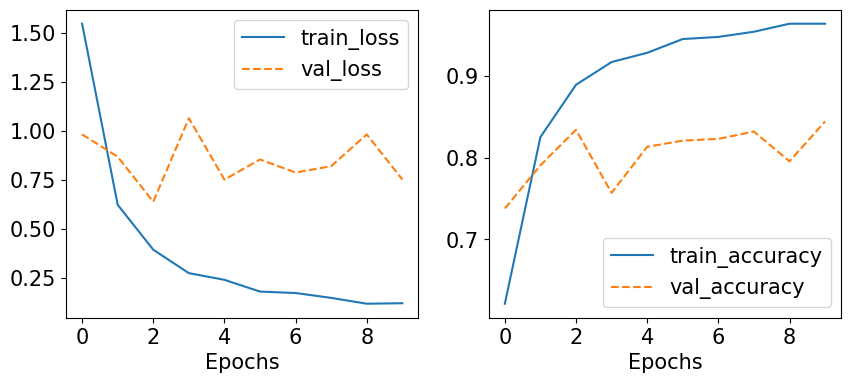

In [ ]:
model.to(device)

num_epochs=10
lr_start = 1e-3 # default in Adam constructor
l1 = 0
l2 = 0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_start, eps=1e-4)

history = train_loop(model, trainloader, valloader, criterion, optimizer, num_epochs, l1=l1, l2=l2)
training_plot(history)

In [ ]:
# save trained model
torch.save(model.state_dict(), "xception.pt")

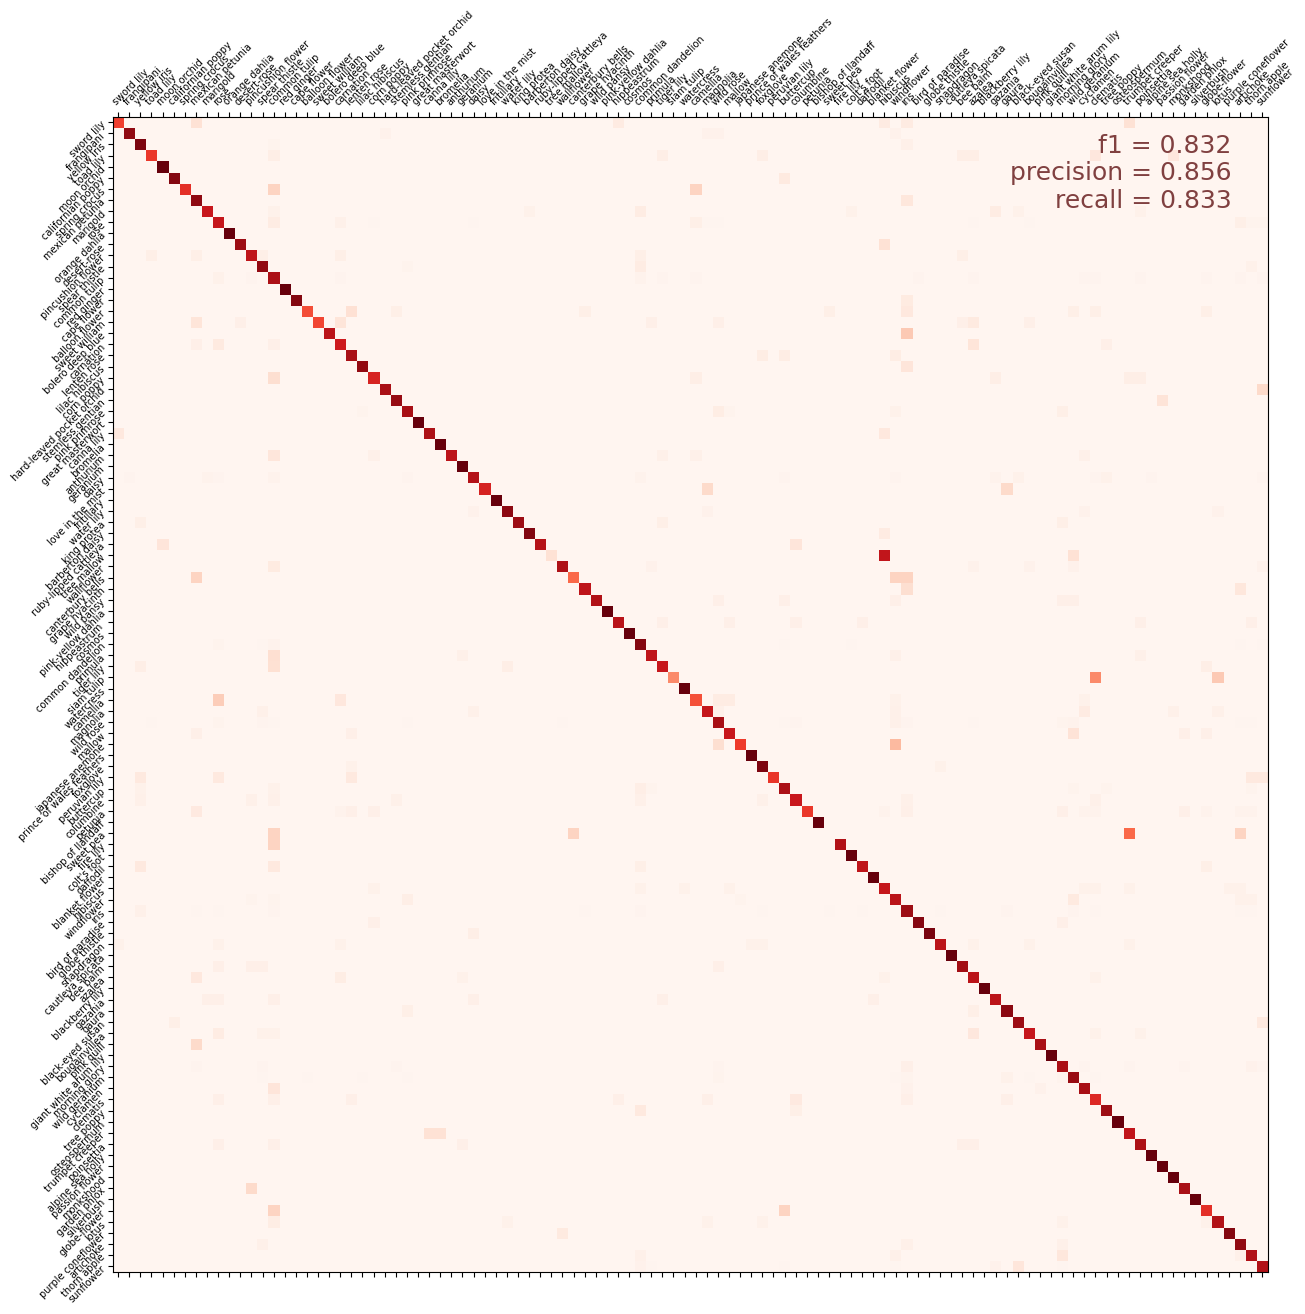

f1 score: 0.832, precision: 0.856, recall: 0.833


In [ ]:
import math, re, os, sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

cm_correct_labels = []
cm_predictions = []

## validation step
model.eval()
for i, (images, labels) in enumerate(valloader):

    images = preprocess(images)
    images = images.to(device)
    cm_correct_labels.extend(list(labels.numpy()))

    with torch.no_grad():
        ## forward + loss
        logits = model(images)
        probs = s(logits)
        outputs = torch.argmax(probs, dim=1)
        cm_predictions.extend(list(outputs.cpu().numpy()))

cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

# Ensembling

In [ ]:
def get_logits_and_predictions(model):
    all_logits = []
    all_probs = []
    model.eval()
    for i, (images, labels) in enumerate(valloader):

        images = preprocess(images).float()
        images = images.to(device)

        with torch.no_grad():
            logits = model(images)
            probs = s(logits)
            all_logits.extend(logits)
            all_probs.extend(probs)

    return all_logits, all_probs

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# DenseNet121
class CustomModel(nn.Module):
    def __init__(self) -> None:
        super(CustomModel, self).__init__()
        self.densenet121 = torchvision.models.densenet121(weights='DEFAULT')
        self.pool = torch.nn.functional.adaptive_avg_pool2d
        self.linear1 = torch.nn.Linear(1024, 104)

    def forward(self, x):
        x = self.densenet121.features(x)
        x = self.pool(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return x

densenet = CustomModel()
# densenet.load_state_dict(torch.load("densenet121.pt"))
densenet.to(device)

logits1, probabilities1 = get_logits_and_predictions(densenet)

In [ ]:
# EfficientNetB6
class CustomModel(nn.Module):
    def __init__(self) -> None:
        super(CustomModel, self).__init__()
        self.efficientnet_b6 = torchvision.models.efficientnet_b6(weights='DEFAULT')
        self.pool = torch.nn.functional.adaptive_avg_pool2d
        self.linear1 = torch.nn.Linear(2304, 104)

    def forward(self, x):
        x = self.efficientnet_b6.features(x)
        x = self.pool(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return x

efficientnet = CustomModel()
# efficientnet.load_state_dict(torch.load("efficientnet_b6.pt"))
efficientnet.to(device)

logits2, probabilities2 = get_logits_and_predictions(efficientnet)

In [ ]:
import timm

# EfficientNetB6
xception = timm.create_model('xception', pretrained=True, num_classes=104)
xception.load_state_dict(torch.load("xception.pt"))
xception.to(device)

logits3, probabilities3 = get_logits_and_predictions(xception)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
<ipython-input-17-92e4e73eac06>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

## Option1: average logits (before softmax - theoretically better)

In [ ]:
def compute_confusion_metrics(correct_labels, predictions):
    cmat = confusion_matrix(correct_labels, predictions, labels=range(len(CLASSES)))
    score = f1_score(correct_labels, predictions, labels=range(len(CLASSES)), average='macro')
    precision = precision_score(correct_labels, predictions, labels=range(len(CLASSES)), average='macro')
    recall = recall_score(correct_labels, predictions, labels=range(len(CLASSES)), average='macro')
    cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
    #display_confusion_matrix(cmat, score, precision, recall)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
    return cmat, score, precision, recall

In [ ]:
# average logits and compute predictions
# logits1 = torch.stack(logits1, dim=0)
# logits2 = torch.stack(logits2, dim=0)
# logits3 = torch.stack(logits3, dim=0)

logits = torch.stack([logits1, logits2, logits3], axis=2)
weights = [0.4, 0.5, 0.1] # the average can be weighted
logits = torch.mean(logits.cpu().detach()*torch.Tensor(weights), axis=2)
probabilities = s(logits)
predictions = torch.argmax(probabilities, axis=-1)

In [ ]:
predictions.shape

torch.Size([3712])

In [ ]:
cm_correct_labels = []
## validation step
model.eval()
for i, (images, labels) in enumerate(valloader):
    cm_correct_labels.extend(list(labels.numpy()))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


f1 score: 0.791, precision: 0.817, recall: 0.804


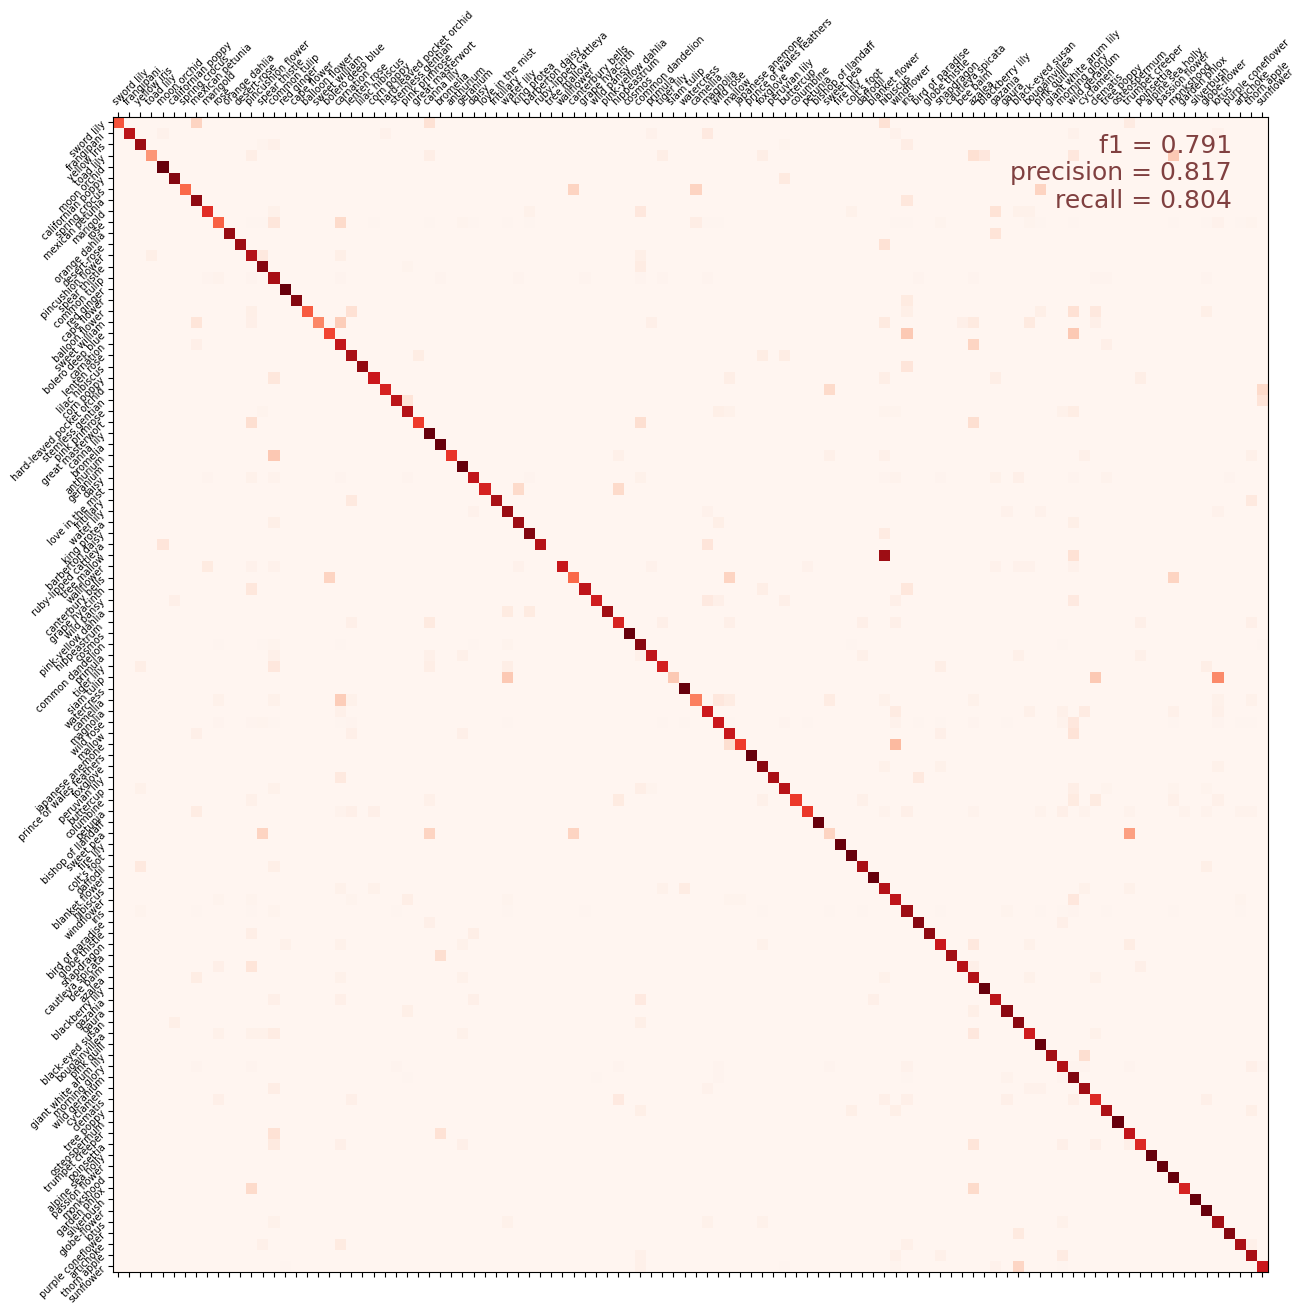

In [ ]:
#compare with correct values
correct_labels = cm_correct_labels
cmat, score, precision, recall = compute_confusion_metrics(correct_labels, predictions.numpy())
display_confusion_matrix(cmat, score, precision, recall)

## Option 2: average probabilities (after softmax - theoretically not as good as Option1)

In [ ]:
probabilities1[0].shape

torch.Size([104])

In [ ]:
# probabilities1 = torch.stack(probabilities1, dim=0)
# probabilities2 = torch.stack(probabilities2, dim=0)
# probabilities3 = torch.stack(probabilities3, dim=0)

probabilities = torch.stack([probabilities1,
                             probabilities2,
                             probabilities3], axis=2)
weights = [0.4, 0.5, 0.1] # the average can be weighted
probabilities = torch.mean(probabilities.cpu().detach()*torch.Tensor(weights), axis=2)
predictions = torch.argmax(probabilities, axis=-1)

f1 score: 0.831, precision: 0.855, recall: 0.832


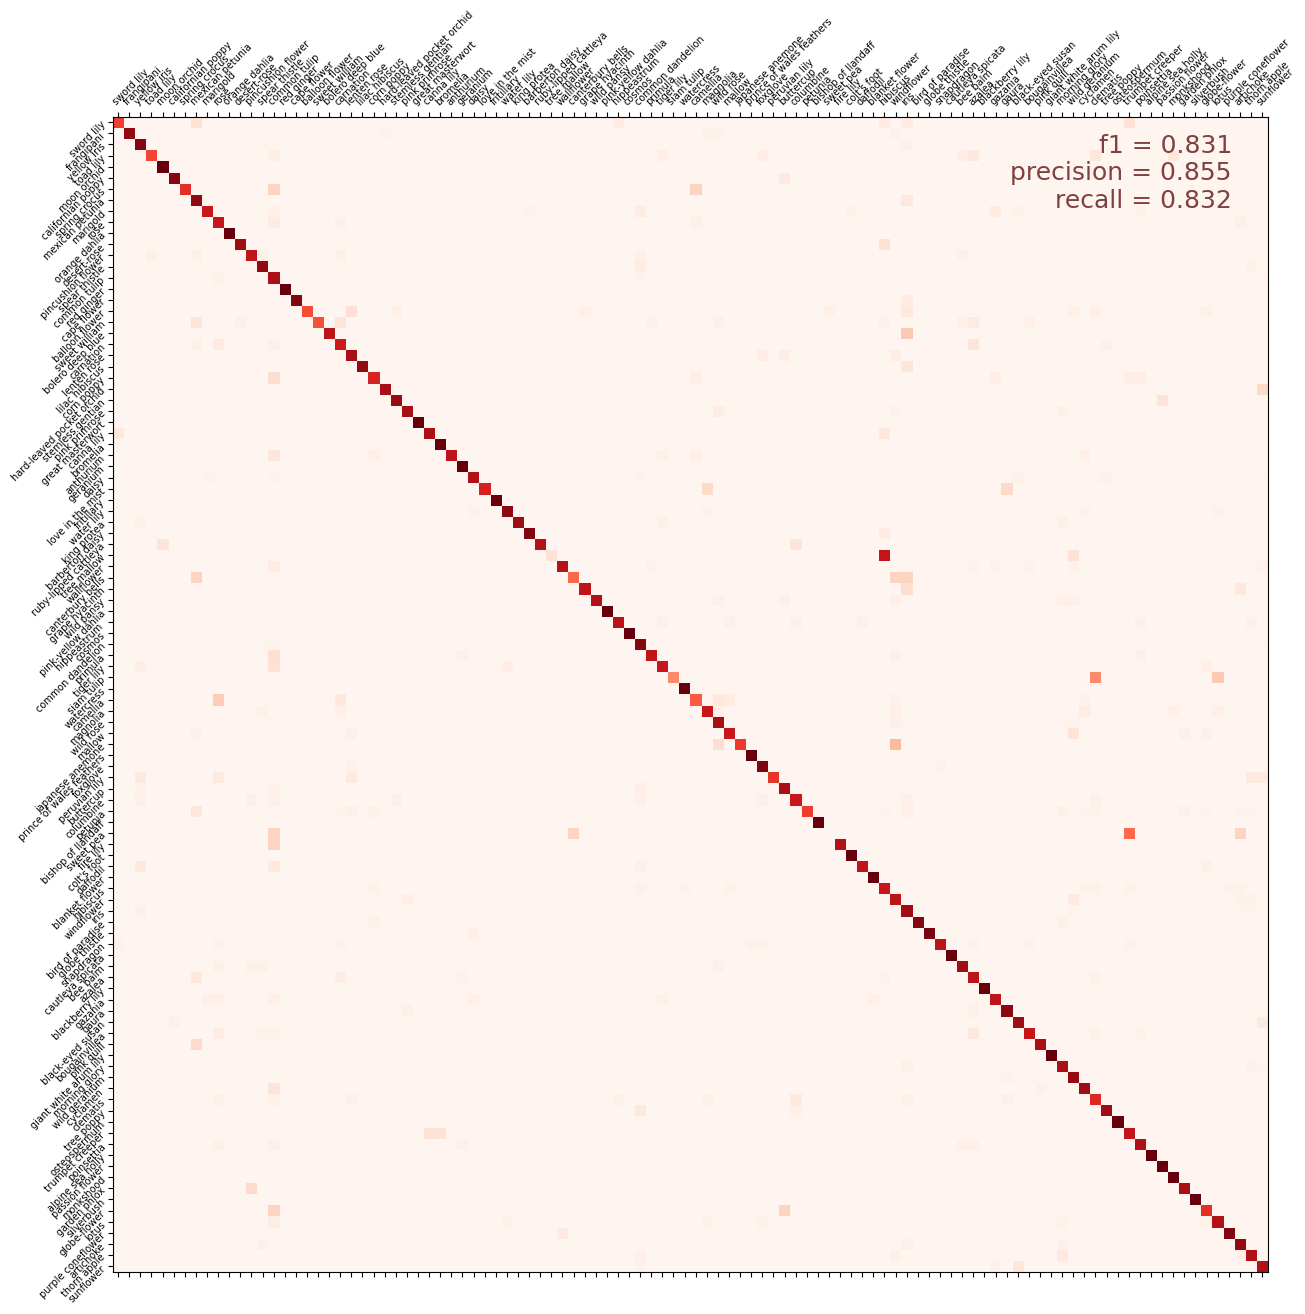

In [ ]:
cmat, score, precision, recall = compute_confusion_metrics(correct_labels, predictions.numpy())
display_confusion_matrix(cmat, score, precision, recall)

# Visual validation

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

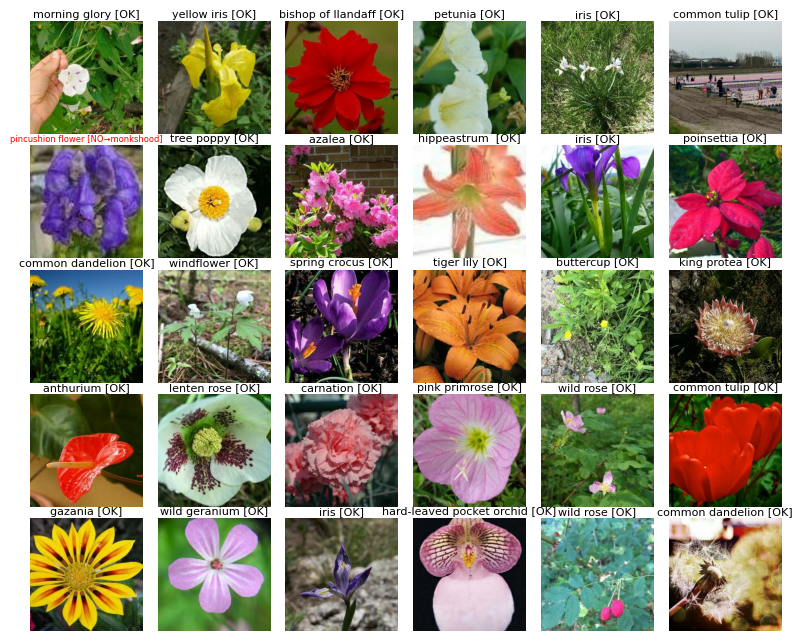

In [ ]:
# run this cell again for next set of images
images, labels = next(iter(trainloader))
probabilities = model(images.to(device))
predictions = np.argmax(probabilities.cpu().detach().numpy(), axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
torch.cuda.empty_cache()

## License
Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.